In [1]:
import glob
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
def extract_params(file):
    
    with open(file, 'r') as f:
        content = f.readlines()
        
    flag_time = 0
    flag_memory = 0
    search_time = -1
    total_time = -1
    memory = -1
    for line in content:
        # print(line)
        if 'expanded' in line and 'until last jump' not in line:
            expanded_states = int(line.split('expanded')[0].split(',')[-1].strip())
        if 'evaluated' in line and 'until last jump' not in line:
            evaluated_states = int(line.split('evaluated')[0].split(',')[-1].strip())
            
        if 'Search time:' in line and flag_time == 0:
            search_time = float(line.split('Search time:')[-1].split('s')[0].strip())
        if 'Planner time:' in line and flag_time == 0:
            total_time = float(line.split('Planner time:')[-1].split('s')[0].strip())
        if 'Peak memory:' in line and flag_memory == 0:
            memory = int(line.split('Peak memory:')[-1].split('KB')[0].strip())
    
        if 'caught signal 15' in line:
            search_time = -1
            total_time = -1
            flag_time = 1
        
        if 'Memory limit has been reached' in line:
            memory = -1
            search_time = -1
            flag_memory = 1

    return expanded_states, evaluated_states, search_time, total_time, memory

In [14]:
folders = glob.glob('*')
# folders = [folder for folder in folders if os.path.isdir(folder) and ('clemens' in folder or 'sas' in folder)]
folders = [folder for folder in folders if os.path.isdir(folder) and ('DeepCubeA' not in folder) and ('sas_variables' not in folder) ]

results = {}

for key in folders:
    results[key] = {folder.split('/')[-1]: {'expanded': [10**9 for i in range(20)], 
                                            'evaluated': [10**9 for i in range(20)], 
                                            'memory': [10**7 for i in range(20)], 
                                            'time': [10**4 for i in range(20)], 
                                            'plan_status': [0 for i in range(20)]} for folder in glob.glob(key + '/*') if not ('max' in folder and '-' not in folder)}

In [15]:
results.keys()

dict_keys(['SAS-18', 'PDDL-18', 'SAS-12', 'PDDL-12'])

In [16]:
for fold in results.keys():
    for sub_fold in results[fold].keys():
        output_files = glob.glob(os.path.join(fold, sub_fold, '*output*'))
        for out in output_files:
            # print(fold, sub_fold, os.path.basename(out))
            params_file = out.replace('output', 'params').replace('txt', 'json')
            file_name = os.path.basename(params_file)
            # extract number from file name
            problem_number = int(re.findall(r'\d+', file_name)[0])

            expanded_states, evaluated_states, search_time, total_time, memory = extract_params(out)

            if os.path.exists(params_file):
                # load params json file
                with open(params_file, 'r') as f:
                    params = json.load(f)
                
                results[fold][sub_fold]['evaluated'][problem_number-1] = params['evaluated']
                results[fold][sub_fold]['expanded'][problem_number-1] = params['expanded']
                results[fold][sub_fold]['time'][problem_number-1] = params['total_time']
                results[fold][sub_fold]['plan_status'][problem_number-1] = 1
                if memory != -1:
                    results[fold][sub_fold]['memory'][problem_number-1] = memory
            

In [17]:
import seaborn as sns
import warnings
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings('ignore', category=UserWarning)

sns.set_style('whitegrid')
# sns.set_palette('Greys')
sns.set_palette('colorblind')

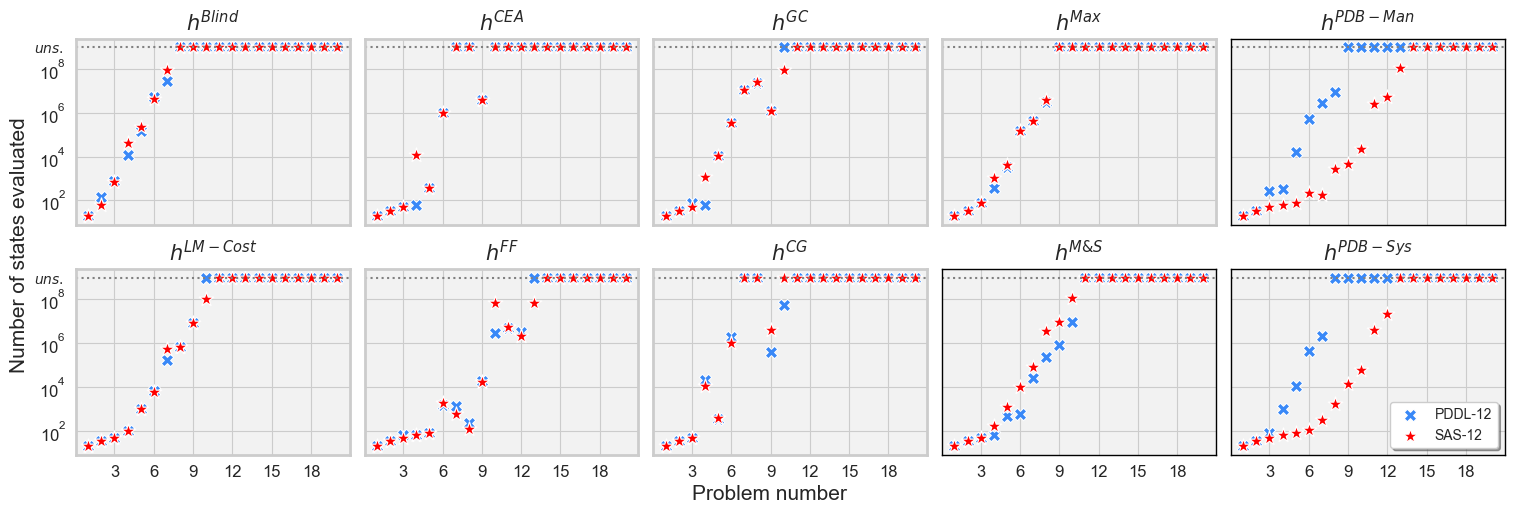

In [18]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(2,5, figsize=(15, 5), sharey=True, sharex=True)

heuristics_list = ['blind', 'context_enhanced_additive', 'goal_count', 'max', 'max-manual-pdb', 'lm_cost', 'ff', 'causal_graph', 'merge-and-shrink', 'max-systematic-pdb',]

# Heuristic notation mapping
heuristic_notations = {
    'blind': r'$h^{Blind}$',
    'context_enhanced_additive': r'$h^{CEA}$',
    'goal_count': r'$h^{GC}$',
    'max': r'$h^{Max}$',
    'max-manual-pdb': r'$h^{PDB-Man}$',
    'lm_cost': r'$h^{LM-Cost}$',
    'ff': r'$h^{FF}$',
    'causal_graph': r'$h^{CG}$',
    'merge-and-shrink': r'$h^{M&S}$',
    'max-systematic-pdb': r'$h^{PDB-Sys}$'
}

# set fig x and y labels
fig.text(0.5, 0, 'Problem number', ha='center', va='center', size=15)
fig.text(0, 0.5, 'Number of states evaluated', ha='center', va='center', rotation='vertical', size=15)

count = 0
for item in heuristics_list:
    x_idx = count // 5
    y_idx = count % 5

    ax[x_idx, y_idx].set_yscale('log')

    ax[x_idx, y_idx].set_title(heuristic_notations[item], size=15)  # Updated to use heuristic notation

    # ax[x_idx, y_idx].set_ylabel('Number of evaluated states')
    # ax[x_idx, y_idx].set_xlabel('problem number')

    sns.scatterplot(x=range(1,21), y=results['PDDL-18'][item]['evaluated'], ax=ax[x_idx, y_idx], label='PDDL-12', marker='X', s=80, color="#3988f7")
    # sns.scatterplot(x=range(20), y=results['PDDL-18'][item]['evaluated'], ax=ax[x_idx, y_idx], label='PDDL-18')
    sns.scatterplot(x=range(1,21), y=results['SAS-18'][item]['evaluated'], ax=ax[x_idx, y_idx], label='SAS-12', marker='*', s=120, color= "#FF0000")
    # sns.scatterplot(x=range(20), y=results['SAS-18'][item]['evaluated'], ax=ax[x_idx, y_idx], label='SAS-18')

    # vertical line at x = 10
    # ax[x_idx, y_idx].axvline(x=10, color='black', linestyle='--', label='ipc-23 bench.')
    # add legend only for last plot
    if count == len(heuristics_list)-1:
        # want legend on top of the figure outside the plot
        ax[x_idx, y_idx].legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=1, fancybox=True, shadow=True)
    else:
        ax[x_idx, y_idx].legend().remove()

    # ax bold outline for each plot
    for axis in ['top','bottom','left','right']:
        if ('pdb' in item) or ('merge' in item):
            # change outline color
            ax[x_idx, y_idx].spines[axis].set_color('black')
            ax[x_idx, y_idx].spines[axis].set_linewidth(1)
        else:
            ax[x_idx, y_idx].spines[axis].set_linewidth(2)

    ax[x_idx, y_idx].set_facecolor('#f2f2f2')

    # plot only integer ticks on x axis 0, 5, 10, 15, 20
    ax[x_idx, y_idx].xaxis.set_major_locator(MaxNLocator(integer=True))
    # increase font size of x and y ticks
    ax[x_idx, y_idx].tick_params(axis='both', which='major', labelsize=12)

    ax[x_idx, y_idx].axhline(y=10**9, color='grey', linestyle='dotted' )

    # Add y-tick for the dotted line
    ax[x_idx, y_idx].set_yticks([10**9], minor=True)
    ax[x_idx, y_idx].set_yticklabels([r'$uns.$'], minor=True) # This will display the tick label in the form 10^9
    ax[x_idx, y_idx].tick_params(axis='y', which='minor', size=5) # This ensures that the minor tick is visible


    count += 1
fig.tight_layout()


In [25]:
####################################### Check if the plans are optimal for 12 action models ##########################################

optimal_plans_path = '../ipc-23-PDDL/dataset/optimal-plans_18/'

for fold in results.keys():
    if '12' in fold:
        continue
    for sub_fold in results[fold].keys():
        param_files = glob.glob(os.path.join(fold, sub_fold, '*params*.json'))
        count = 0
        for file in param_files:
            file_name = os.path.basename(file)
            # extract number from file name
            problem_number = int(re.findall(r'\d+', file_name)[0])

            with open(file, 'r') as f:
                params = json.load(f)

            plan_cost = params['plan_length']
            
            with open(os.path.join(optimal_plans_path, file_name.split('-')[0] + '.txt'), 'r') as f:
                content = f.readlines()
        
            optimal_plan_cost = len(content)-1                                        
            
            if plan_cost <= optimal_plan_cost:
                count += 1
        print(fold, sub_fold, count, len(param_files), (count/len(param_files))*100)
        print('-------------------')
            

SAS-18 blind 7 7 100.0
-------------------
SAS-18 merge-and-shrink 10 10 100.0
-------------------
SAS-18 max-systematic-pdb 12 12 100.0
-------------------
SAS-18 context_enhanced_additive 5 7 71.42857142857143
-------------------
SAS-18 max-manual-pdb 13 13 100.0
-------------------
SAS-18 goal_count 10 10 100.0
-------------------
SAS-18 max 8 8 100.0
-------------------
SAS-18 lm_cost 10 10 100.0
-------------------
SAS-18 ff 10 13 76.92307692307693
-------------------
SAS-18 causal_graph 5 7 71.42857142857143
-------------------
PDDL-18 blind 7 7 100.0
-------------------
PDDL-18 merge-and-shrink 10 10 100.0
-------------------
PDDL-18 max-systematic-pdb 7 7 100.0
-------------------
PDDL-18 context_enhanced_additive 5 7 71.42857142857143
-------------------
PDDL-18 max-manual-pdb 8 8 100.0
-------------------
PDDL-18 goal_count 9 9 100.0
-------------------
PDDL-18 max 8 8 100.0
-------------------
PDDL-18 lm_cost 9 9 100.0
-------------------
PDDL-18 ff 8 12 66.66666666666666
--

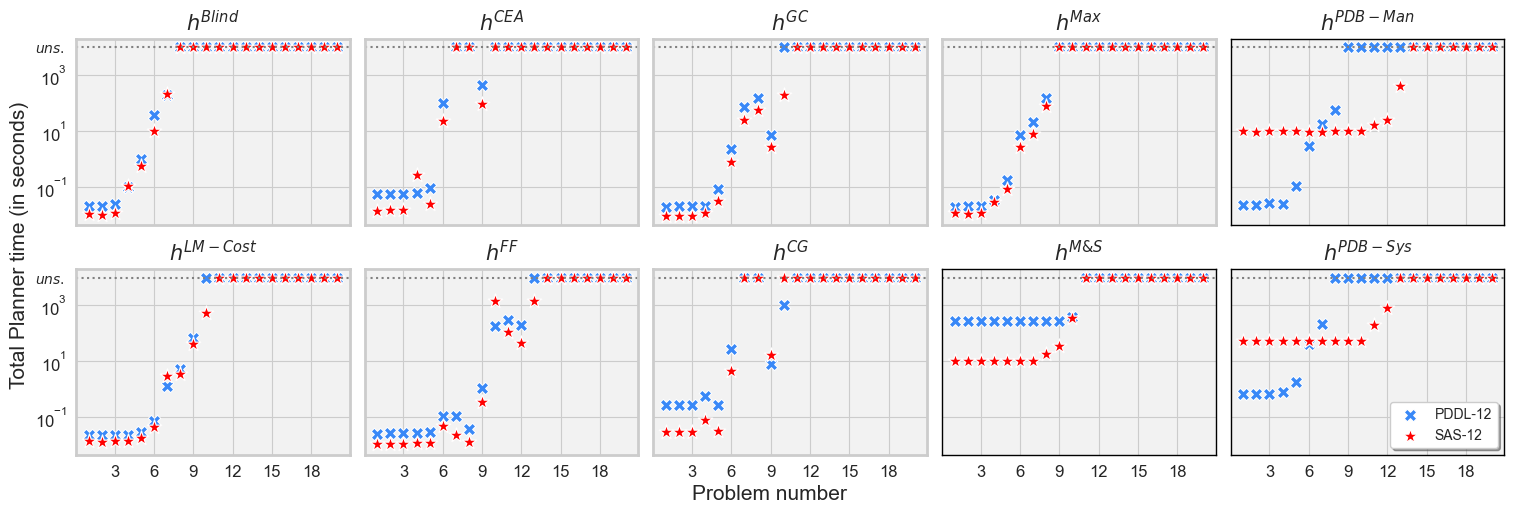

In [23]:
from matplotlib.ticker import MaxNLocator


fig, ax = plt.subplots(2,5, figsize=(15, 5), sharey=True, sharex=True)

heuristics_list = ['blind', 'context_enhanced_additive', 'goal_count', 'max', 'max-manual-pdb', 'lm_cost', 'ff', 'causal_graph', 'merge-and-shrink', 'max-systematic-pdb',]

heuristic_notations = {
    'blind': r'$h^{Blind}$',
    'context_enhanced_additive': r'$h^{CEA}$',
    'goal_count': r'$h^{GC}$',
    'max': r'$h^{Max}$',
    'max-manual-pdb': r'$h^{PDB-Man}$',
    'lm_cost': r'$h^{LM-Cost}$',
    'ff': r'$h^{FF}$',
    'causal_graph': r'$h^{CG}$',
    'merge-and-shrink': r'$h^{M&S}$',
    'max-systematic-pdb': r'$h^{PDB-Sys}$'
}

# set fig x and y labels
fig.text(0.5, 0, 'Problem number', ha='center', va='center', size=15)
fig.text(0, 0.5, 'Total Planner time (in seconds)', ha='center', va='center', rotation='vertical', size=15)


count = 0
for item in heuristics_list:
    x_idx = count // 5
    y_idx = count % 5

    ax[x_idx, y_idx].set_yscale('log')

    ax[x_idx, y_idx].set_title(heuristic_notations[item], size=15)
    # ax[x_idx, y_idx].set_ylabel('Number of evaluated states')
    # ax[x_idx, y_idx].set_xlabel('problem number')

    sns.scatterplot(x=range(1,21), y=results['PDDL-18'][item]['time'], ax=ax[x_idx, y_idx], label='PDDL-12', marker='X', s=80, color="#3988f7")
    # sns.scatterplot(x=range(20), y=results['PDDL-18'][item]['evaluated'], ax=ax[x_idx, y_idx], label='PDDL-18')
    sns.scatterplot(x=range(1,21), y=results['SAS-18'][item]['time'], ax=ax[x_idx, y_idx], label='SAS-12', marker='*', s=120, color= "#FF0000")
    # sns.scatterplot(x=range(20), y=results['SAS-18'][item]['evaluated'], ax=ax[x_idx, y_idx], label='SAS-18')

    # vertical line at x = 10
    # ax[x_idx, y_idx].axvline(x=10, color='black', linestyle='--', label='ipc-23 bench.')
    # add legend only for last plot
    if count == len(heuristics_list)-1:
        # want legend on top of the figure outside the plot
        ax[x_idx, y_idx].legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=1, fancybox=True, shadow=True)
    else:
        ax[x_idx, y_idx].legend().remove()

    # ax bold outline for each plot
    for axis in ['top','bottom','left','right']:
        if ('pdb' in item) or ('merge' in item):
            # change outline color
            ax[x_idx, y_idx].spines[axis].set_color('black')
            ax[x_idx, y_idx].spines[axis].set_linewidth(1)
        else:
            ax[x_idx, y_idx].spines[axis].set_linewidth(2)

    ax[x_idx, y_idx].set_facecolor('#f2f2f2')

    # plot only integer ticks on x axis 0, 5, 10, 15, 20
    ax[x_idx, y_idx].xaxis.set_major_locator(MaxNLocator(integer=True))
    # increase font size of x and y ticks
    ax[x_idx, y_idx].tick_params(axis='both', which='major', labelsize=12)

    ax[x_idx, y_idx].axhline(y=10**4, color='grey', linestyle='dotted' )

    # Add y-tick for the dotted line
    ax[x_idx, y_idx].set_yticks([10**4], minor=True)
    ax[x_idx, y_idx].set_yticklabels([r'$uns.$'], minor=True) # This will display the tick label in the form 10^9
    ax[x_idx, y_idx].tick_params(axis='y', which='minor', size=5) # This ensures that the minor tick is visible



    count += 1
fig.tight_layout()


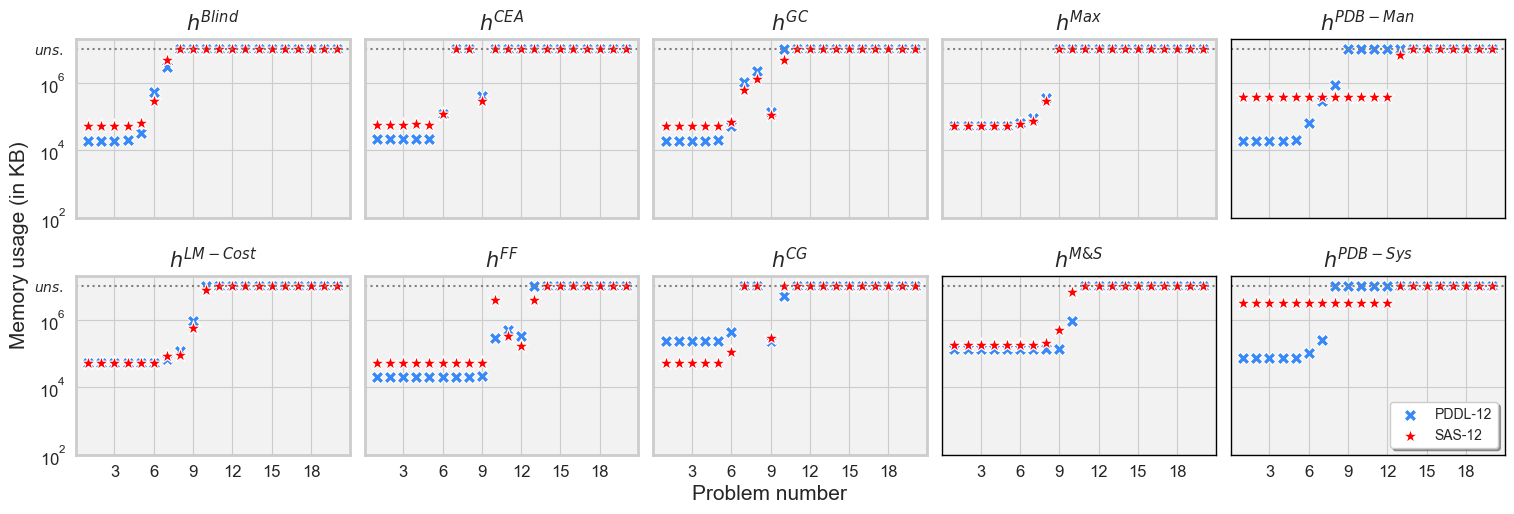

In [24]:
from matplotlib.ticker import MaxNLocator


fig, ax = plt.subplots(2,5, figsize=(15, 5), sharey=True, sharex=True)

heuristics_list = ['blind', 'context_enhanced_additive', 'goal_count', 'max', 'max-manual-pdb', 'lm_cost', 'ff', 'causal_graph', 'merge-and-shrink', 'max-systematic-pdb',]

heuristic_notations = {
    'blind': r'$h^{Blind}$',
    'context_enhanced_additive': r'$h^{CEA}$',
    'goal_count': r'$h^{GC}$',
    'max': r'$h^{Max}$',
    'max-manual-pdb': r'$h^{PDB-Man}$',
    'lm_cost': r'$h^{LM-Cost}$',
    'ff': r'$h^{FF}$',
    'causal_graph': r'$h^{CG}$',
    'merge-and-shrink': r'$h^{M&S}$',
    'max-systematic-pdb': r'$h^{PDB-Sys}$'
}


# set fig x and y labels
fig.text(0.5, 0, 'Problem number', ha='center', va='center', size=15)
fig.text(0, 0.5, 'Memory usage (in KB)', ha='center', va='center', rotation='vertical', size=15)

count = 0
for item in heuristics_list:
    x_idx = count // 5
    y_idx = count % 5

    ax[x_idx, y_idx].set_yscale('log')

    ax[x_idx, y_idx].set_title(heuristic_notations[item], size=15)
    # ax[x_idx, y_idx].set_ylabel('Number of evaluated states')
    # ax[x_idx, y_idx].set_xlabel('problem number')

    sns.scatterplot(x=range(1,21), y=results['PDDL-18'][item]['memory'], ax=ax[x_idx, y_idx], label='PDDL-12', marker='X', s=80, color="#3988f7")
    # sns.scatterplot(x=range(20), y=results['PDDL-18'][item]['evaluated'], ax=ax[x_idx, y_idx], label='PDDL-18')
    sns.scatterplot(x=range(1,21), y=results['SAS-18'][item]['memory'], ax=ax[x_idx, y_idx], label='SAS-12', marker='*', s=120, color= "#FF0000")
    # sns.scatterplot(x=range(20), y=results['SAS-18'][item]['evaluated'], ax=ax[x_idx, y_idx], label='SAS-18')

    # vertical line at x = 10
    # ax[x_idx, y_idx].axvline(x=10, color='black', linestyle='--', label='ipc-23 bench.')
    # add legend only for last plot
    if count == len(heuristics_list)-1:
        # want legend on top of the figure outside the plot
        ax[x_idx, y_idx].legend(loc='lower right', bbox_to_anchor=(1, 0), ncol=1, fancybox=True, shadow=True)
    else:
        ax[x_idx, y_idx].legend().remove()

    # ax bold outline for each plot
    for axis in ['top','bottom','left','right']:
        if ('pdb' in item) or ('merge' in item):
            # change outline color
            ax[x_idx, y_idx].spines[axis].set_color('black')
            ax[x_idx, y_idx].spines[axis].set_linewidth(1)
        else:
            ax[x_idx, y_idx].spines[axis].set_linewidth(2)

    ax[x_idx, y_idx].set_facecolor('#f2f2f2')

    # plot only integer ticks on x axis 0, 5, 10, 15, 20
    ax[x_idx, y_idx].xaxis.set_major_locator(MaxNLocator(integer=True))
    # increase font size of x and y ticks
    ax[x_idx, y_idx].tick_params(axis='both', which='major', labelsize=12)

    # set y limit only base to 100
    ax[x_idx, y_idx].set_ylim(bottom=100, top=10**7*2 )

    # draw a line at y = 10**7 to show the memory limit and set y tick at this line as 'uns.' 
    # ax[x_idx, y_idx].set_yticks([10**7])
    # ax[x_idx, y_idx].set_yticklabels(['uns.'])
    # add other y ticks

    ax[x_idx, y_idx].axhline(y=10**7, color='grey', linestyle='dotted' )
    
    # Add y-tick for the dotted line
    ax[x_idx, y_idx].set_yticks([10**7], minor=True)
    ax[x_idx, y_idx].set_yticklabels([r'$uns.$'], minor=True) # This will display the tick label in the form 10^9
    ax[x_idx, y_idx].tick_params(axis='y', which='minor', size=5) # This ensures that the minor tick is visible


    count += 1
fig.tight_layout()
